In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipynb
from scipy.spatial import distance_matrix
import random
import sys as sys
import time
import re

In [236]:
from ipynb.fs.full.datamanagement import user_filter, summarise_listening_history
from ipynb.fs.full.evaluation_workflow import split_history, scoring_accuracy_vs_serendipity, scoring_in_out
from ipynb.fs.full.feature_based_algos import get_listenings_history_partition, kmeans_based_ranking


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, auc

from scipy.spatial import distance_matrix

In [334]:
import json

## Data loading

In [3]:
# Read the data
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [4]:
df['track_id'] = df.song_name + '-' + df.artist_name

In [5]:
len(df)

4982520

## Data management

In [6]:
## keep first occurence of a given song/artist instance to reduce redundant observations

df = df.drop_duplicates(subset = ['user','track_id'], keep='first')
len(df)

4973744

### Users filtering

In [8]:
users_summary = summarise_listening_history(df)

In [9]:
ids = user_filter(users_summary, nlist_min = 1, nlist_max = 500, ntracks_min = 5)

In [10]:
wdf = df.loc[df['user'].isin(ids),:]
wdf_users_summary = users_summary.loc[users_summary['user'].isin(ids),:]

In [11]:
print('Nb of ligns in df  :', len(df))
print('Nb of ligns in wdf :', len(wdf))

Nb of ligns in df  : 4973744
Nb of ligns in wdf : 3856377


In [12]:
len(wdf_users_summary)

327081

In [13]:
wdf_users_summary.head()

,user,listening_count,track_count
7,00007ed2509128dcdd74ea3aac2363e24e9dc06b,11,10
11,0000bb531aaa657c932988bc2f7fd7fc1b2050ec,14,10
12,0000d3c803e068cf1da17724f1674897b2dd7130,7,5
14,0000f88f8d76a238c251450913b0d070e4a77d19,30,8
15,000138e252eea35fd73aaf66a9b34102b695a9c8,26,13


### Songs management

In [14]:
# Get the songs quantitative features

tracks_feats = df.drop(['user', 'listening_count'],axis = 1)
tracks_feats['track_id'] = df.song_name + '-' + df.artist_name
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date', 'duration', 'tempo'], axis = 1).drop_duplicates()

In [15]:
# Normalize the songs quantitative feats
X = tracks_quanti_feats.drop(['track_id'], axis = 1)
X.index = tracks_quanti_feats.track_id

scaler = StandardScaler()
X[X.columns] = pd.DataFrame(scaler.fit_transform(X), index=X.index)


In [16]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
track_id,,,,,,,,
Stronger-Kanye West,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057
Stacked Actors-Foo Fighters,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483
Clarity-John Mayer,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664
Gimme Stitches-Foo Fighters,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438
Breakout-Foo Fighters,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617
...,...,...,...,...,...,...,...,...
Dime-Jerry Rivera,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983
The Long Conversation-Pierre de Reeder,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032
That's the Way That It Was-Pierre de Reeder,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940


## Recommendation algorithms evaluation

In [17]:
wdf_sorted = wdf.sort_values('user')
wdf_users_summary_sorted = wdf_users_summary.sort_values('user')

In [21]:
# Try 1; Triplets non sorted by users, without users_summary
st = time.time()
test1, test2 = split_history(wdf, 0.2, sort = True, random_state = 1234)
et = time.time()
elapsed_time = et - st
print('Execution time 1:', elapsed_time, 'seconds')

Sorting the triplets by users id ... Done
Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 1: 42.95786738395691 seconds


In [22]:
# Try 2: Triplets non sorted by users, with users_summary
st = time.time()
test1, test2 = split_history(wdf, 0.2, sort = True, users_summary = wdf_users_summary, random_state = 1234)
et = time.time()
elapsed_time = et - st
print('Execution time 2:', elapsed_time, 'seconds')

Sorting the triplets by users id ... Done
Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 2: 36.215386390686035 seconds


In [23]:
# Try 3: Triplets sorted by users, without users_summary
st = time.time()
test1, test2 = split_history(wdf_sorted, 0.2, sort = False, random_state = 1234)
et = time.time()
elapsed_time = et - st
print('Execution time 3:', elapsed_time, 'seconds')


Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 2: 21.979166746139526 seconds


In [18]:
# Try 4: Triplets sorted by users, without users_summary
st = time.time()
test1, test2 = split_history(wdf_sorted, 0.2, sort = False, users_summary = wdf_users_summary_sorted, random_state = 1234)
et = time.time()
elapsed_time = et - st
print('\n Execution time 4:', elapsed_time, 'seconds')


Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...
 Execution time 4: 10.474013566970825 seconds


### Definition of the grid of parameters

In [30]:
# n_neighbors = [10, 25, 50, 100, 150, 200]

### Initialize the table of results  

In [130]:
# results = pd.DataFrame({
#     'user' : wdf_users_summary_sorted.user,
#     'listening_count' : wdf_users_summary_sorted.listening_count,
#     'track_count' :  wdf_users_summary_sorted.track_count
# })

# for r in ['n_reco-'+ str(n)+ '-' + i  for n in n_neighbors for i in ("reco_in","reco_out")]:
#     results[r] = None
# results = results.melt(id_vars = ['user', 'listening_count', 'track_count']).sort_values('user')
# results['n_reco'] =  results.variable.str.extract(r'([0-9]+)').astype('int')
# results['reco_type'] =  results.variable.str.extract(r'(reco_.+)')
# results = results.drop(['variable'], axis = 1)
# results.to_csv('../data/reco_res.csv')

In [31]:
results = pd.read_csv('../data/reco_res.csv')

In [32]:
results.head()

,Unnamed: 0,user,listening_count,track_count,n_hidden,n_reco,reco_in,reco_out
0,539,006efbbc4ab2dbc89a4b352282919c1d27ee7c74,19,12,2.0,10.0,0.0,10.0
1,981,00c2ffb64177c627f5fb3c9f101208123aaf298c,46,5,1.0,10.0,0.0,10.0
2,1107,00e090ae8c47db1be5f7061b01eddced92c3c435,19,11,2.0,10.0,0.0,10.0
3,1542,0139472c899f9b6eb9c4a1689f6fd78f1af1be13,12,8,2.0,10.0,0.0,10.0
4,1732,015c7500549e6c6bbd94a06fd2ca8baa7284784f,9,9,2.0,10.0,0.0,10.0


### Random recommandations

In [210]:
sample = user_filter(wdf_users_summary, ntracks_min = 101)

In [211]:
sample

1145      005a475315cd3a29638cf242c4b7c71194e81642
2335      00b9144fc8cd453b81c362b30dbf8b8266eec220
18531     05a82aa743db5b6c5965e72d458d7c0755fd9f0f
20321     062eef2a03b53d2b10f5018135e3361659c6a3bf
23138     070941445cba8e8a9157f1253116cc430c31a811
                            ...                   
831701    fab8d9648b537cd5c2af445a6a5218a8010751b7
837273    fc6538bd1e2db0d960cf5c27e9cb0d5de2cddd22
839920    fd2e8f7a73aceb8ef77e1fcfd58909e815ade83b
844564    fe9a05c03c29da973743a83b80d1660748077432
845758    fef771ab021c200187a419f5e55311390f850a50
Name: user, Length: 174, dtype: object

In [212]:
df_apparent_sample = test1.loc[test1.user.isin(sample),: ]
df_hidden_sample = test2.loc[test2.user.isin(sample),: ]

In [213]:
dic_hidden = { u :df_hidden_sample[['user','track_id']].loc[df_hidden_sample.user == u] for u in sample}

In [274]:
dic_hidden_random_ranks = {u : random.sample(list(np.arange(1,len(X)-len(dic_hidden[u]))),len(dic_hidden[u])) for u in sample}

In [250]:
rand_tpr = [[sum(dic_hidden_random_ranks[u] <= i)/len(dic_hidden_random_ranks[u]) for i in np.arange(1, len(X)+1)] for u in sample]

In [251]:
rand_fpr = [[(i-sum(dic_hidden_random_ranks[u] <= i))/(len(X)-len(dic_hidden_random_ranks[u])) for i in np.arange(1, len(X)+1)] for u in sample]

In [252]:
rand_tpr_avg = np.array(rand_tpr).mean(axis = 0)

In [253]:
rand_fpr_avg = np.array(rand_fpr).mean(axis = 0)

### Average based ranking

In [320]:
dic_avg_ranks = {u : kmeans_based_ranking(
    listenings_history = df_apparent_sample.loc[df_apparent_sample.user == u],
    X = X,
    n_clusters = 1,
    random_state = 1234) for u in sample}

In [321]:
dic_hidden_avg_ranks = {u : list(dic_avg_ranks[u].loc[list(dic_hidden[u].track_id)].min(axis = 1)) for u in sample}

In [328]:
avg_tpr = [[sum(dic_hidden_avg_ranks[u] <= i)/len(dic_hidden_avg_ranks[u]) for i in np.arange(1, len(X)+1)] for u in sample]

In [329]:
avg_fpr = [[(i-sum(dic_hidden_avg_ranks[u] <= i))/(len(X)-len(dic_hidden_avg_ranks[u])) for i in np.arange(1, len(X)+1)] for u in sample]

In [330]:
avg_tpr_avg = np.array(avg_tpr).mean(axis = 0)

In [331]:
avg_fpr_avg = np.array(kmbr_fpr).mean(axis = 0)

### kmeans based ranking

In [258]:
dic_kmbr_ranks = {u : kmeans_based_ranking(
    listenings_history = df_apparent_sample.loc[df_apparent_sample.user == u],
    X = X,
    random_state = 1234) for u in sample}

In [276]:
dic_hidden_kmbr_ranks = {u : list(dic_kmbr_ranks[u].loc[list(dic_hidden[u].track_id)].min(axis = 1)) for u in sample}

In [323]:
kmbr_tpr = [[sum(dic_hidden_kmbr_ranks[u] <= i)/len(dic_hidden_kmbr_ranks[u]) for i in np.arange(1, len(X)+1)] for u in sample]

In [324]:
kmbr_fpr = [[(i-sum(dic_hidden_kmbr_ranks[u] <= i))/(len(X)-len(dic_hidden_kmbr_ranks[u])) for i in np.arange(1, len(X)+1)] for u in sample]

In [325]:
kmbr_tpr_avg = np.array(kmbr_tpr).mean(axis = 0)

In [326]:
kmbr_fpr_avg = np.array(kmbr_fpr).mean(axis = 0)

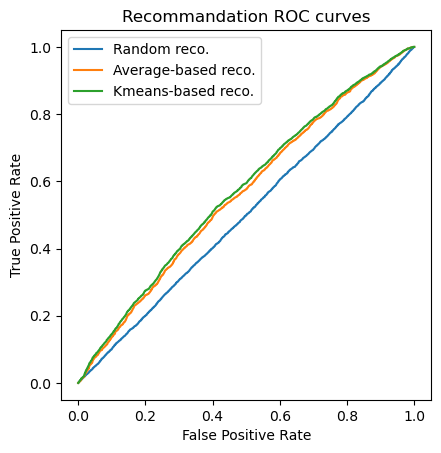

In [335]:
plt.plot(rand_fpr_avg, rand_tpr_avg, label ='Random reco.')
plt.plot(avg_fpr_avg, avg_tpr_avg, label ='Average-based reco.')
plt.plot(kmbr_fpr_avg, kmbr_tpr_avg, label ='Kmeans-based reco.')

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Recommandation ROC curves")
plt.legend()
plt.show()
        

## Work in progress

In [318]:
def kmeans_based_ranking(listenings_history, X, weighted = True, n_clusters = 'auto', random_state = None):  
    # Get the features of the songs listened by the user
    listenings_history_feats = X.loc[listenings_history.track_id]      
    
    # If a weighting of each tracks is desired :
    if weighted:
        # Calculation of the weight of each track according to its number of listens
        w = listenings_history.listening_count / listenings_history.listening_count.sum()
        w.index = listenings_history_feats.index 
        # Tracks weighting
        listenings_history_feats = listenings_history_feats.apply(lambda x: x*w)
    
    # Compute the user tracks centroids
    if n_clusters == 'auto':
        labels, centroids, _ = get_listenings_history_partition(listenings_history_feats)
    elif n_clusters == 1:
        labels = list(np.zeros(len(listenings_history)))
        centroids = np.array(listenings_history_feats.apply('mean'), ndmin = 2)
    else:
        clf = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state = random_state)
        clf.fit(listenings_history_feats)
        centroids = clf.cluster_centers_
        labels = clf.labels_
    
    # Define the number of neighbors to find according to the clusters size
    # cluster_size = pd.Series(labels).value_counts()
    # nb_tracks_by_clusters = [round(n_neighbors * v) for v in cluster_size / sum(cluster_size)]
    # if not sum(nb_tracks_by_clusters) == n_neighbors:
    #     nb_tracks_by_clusters[-1] = n_neighbors - sum(nb_tracks_by_clusters[:-1])
        
    # Compute the distance between the tracks and the centroids  
    D = pd.DataFrame(distance_matrix(X.loc[X.index.difference(listenings_history_feats.index)], centroids), index = X.index.difference(listenings_history_feats.index))           

#     # Get the ranks of the tracks relating to its distance with each centroid
    R = D.rank(axis = 0)

#     # Get the n_neighbors unique recommended tracks
#     recommended_tracks = []
#     for i, n in enumerate(nb_tracks_by_clusters):
#         tracks = [t for t in list(R.iloc[:,i].sort_values().index) if not t in recommended_tracks]
#         recommended_tracks = recommended_tracks + tracks[:n]

    return R